# HORN: Exploring Harmonic Oscillator Network Dynamics

## A Comprehensive Guide to Coupled Oscillatory Neural Networks

This tutorial provides an in-depth exploration of **HORN** (Harmonic Oscillator Recurrent Network), a neural mass model based on coupled damped harmonic oscillators. We'll build understanding progressively from single oscillators to complex networks, examining how parameters control dynamics and comparing with other oscillator models.

---

## Learning Objectives

By the end of this tutorial, you will be able to:

1. **Explain** the physical and biological foundations of damped harmonic oscillator dynamics
2. **Predict** how each parameter (ω, γ, α, v) affects oscillatory behavior
3. **Analyze** single oscillator responses to different input patterns (constant, sinusoidal, step)
4. **Distinguish** between underdamped, critically damped, and overdamped regimes
5. **Design** homogeneous and heterogeneous oscillator networks with desired frequency properties
6. **Implement** different coupling patterns (all-to-all, sparse, ring, small-world)
7. **Demonstrate** the effects of synaptic delays on network synchronization
8. **Compare** HORN with other oscillator models (Hopf, Wilson-Cowan)
9. **Evaluate** integration methods and their stability properties
10. **Apply** HORN to sequence processing and temporal pattern generation tasks

## Imports

In [2]:
import sys
sys.path.append(r'D:\codes\projects\brainmass')
import brainstate
import brainmass

import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

---

## PART 1: FOUNDATIONS

---

### Section 1: Background & Theory

#### 1.1 Introduction to Harmonic Oscillators in Neuroscience

Oscillatory dynamics are fundamental to brain function, appearing at multiple scales from single neurons to large-scale networks. Neural oscillations in the theta (4-8 Hz), alpha (8-13 Hz), beta (13-30 Hz), and gamma (30-100 Hz) bands play crucial roles in:

- **Temporal coordination**: Synchronizing activity across brain regions
- **Working memory**: Maintaining information through sustained oscillations
- **Attention**: Modulating sensory processing via oscillatory gating
- **Motor control**: Generating rhythmic movement patterns

The **harmonic oscillator** provides a mathematically tractable framework for modeling these phenomena. Unlike simple threshold-based models, oscillators naturally capture:

1. **Intrinsic rhythmicity**: Self-sustained periodic activity
2. **Resonance**: Enhanced response to inputs at specific frequencies
3. **Phase relationships**: Temporal coordination between units
4. **Energy dynamics**: Conservation and dissipation properties

#### 1.2 From Simple Harmonic Motion to Damped Driven Oscillators

The evolution of oscillator complexity:

**Simple Harmonic Oscillator (SHO)**:
$$
\frac{d^2x}{dt^2} + \omega^2 x = 0
$$

- Perpetual oscillation at natural frequency $\omega$
- Physically unrealistic (no energy loss)

**Damped Harmonic Oscillator**:
$$
\frac{d^2x}{dt^2} + 2\gamma\frac{dx}{dt} + \omega^2 x = 0
$$

- Damping coefficient $\gamma$ causes exponential decay
- More realistic, but no external drive

**Damped Driven Oscillator (HORN)**:
$$
\frac{d^2x}{dt^2} + 2\gamma\frac{dx}{dt} + \omega^2 x = \alpha \cdot \tanh\left(I(t) + F(x(t), \dot{x}(t))\right)
$$

- External input $I(t)$ drives the system
- Nonlinear coupling $F(x, \dot{x})$ enables network interactions
- Nonlinear activation $\tanh$ bounds the driving force

#### 1.3 HORN Equations and Parameters

The HORN model uses **symplectic Euler integration** to preserve energy properties:

**Velocity update**:
$$
y_{t+1} = y_t + h \cdot \left(\alpha \cdot \tanh(I_{t+1} + F_t) - 2\gamma \cdot y_t - \omega^2 \cdot x_t\right)
$$

**Position update**:
$$
x_{t+1} = x_t + h \cdot y_{t+1}
$$

Where:
- $x$: Position (analogous to neural population activity)
- $y$: Velocity (rate of change of activity)
- $F_t$: Recurrent feedback from network connections

#### 1.4 Parameter Interpretation

| Parameter | Symbol | Physical Meaning | Neural Interpretation | Default | Typical Range |
|-----------|--------|------------------|----------------------|---------|---------------|
| **Natural frequency** | $\omega$ | Intrinsic oscillation rate (rad/timestep) | Preferred rhythm (e.g., theta vs gamma) | $2\pi/28 \approx 0.224$ | 0.1 - 1.0 |
| **Damping coefficient** | $\gamma$ | Energy dissipation rate | Membrane leak / inhibitory regulation | 0.01 | 0.001 - 0.1 |
| **Input gain** | $\alpha$ | Excitability / responsiveness | Synaptic efficacy / excitability | 0.04 | 0.01 - 0.2 |
| **Amplitude feedback** | $v$ | Position-dependent modulation | Activity-dependent gain control | 0.0 | 0.0 - 0.5 |
| **Step size** | $h$ | Integration resolution | Temporal discretization | 1.0 | 0.5 - 2.0 |

**Biological Interpretations**:

- **$\omega$ (Natural Frequency)**: Analogous to the intrinsic firing rate of a neural population, determined by membrane properties, synaptic time constants, and local circuit architecture. Different brain regions exhibit characteristic frequency bands (e.g., hippocampus theta ~8 Hz).

- **$\gamma$ (Damping)**: Represents energy dissipation mechanisms including:
  - Passive membrane leak currents
  - Synaptic depression
  - Inhibitory feedback
  - Higher damping = faster decay to equilibrium

- **$\alpha$ (Input Gain)**: Controls how strongly the population responds to external inputs, analogous to:
  - Synaptic conductance strength
  - Number of active synapses
  - Neuromodulatory state (e.g., acetylcholine increasing excitability)

- **$v$ (Amplitude Feedback)**: Implements activity-dependent gain control, similar to:
  - Spike-frequency adaptation
  - Short-term synaptic plasticity
  - Homeostatic regulation

#### 1.5 Comparison with Other Neural Mass Models

| Model | State Variables | Time Constant | Oscillation Mechanism | Network Interaction |
|-------|----------------|---------------|----------------------|---------------------|
| **HORN** | Position + Velocity | Controlled by $\gamma$, $\omega$ | Intrinsic harmonic | Linear coupling in $F$ |
| **Hopf** | Real + Imaginary | Fixed bifurcation parameter | Supercritical bifurcation | Phase coupling |
| **Wilson-Cowan** | Excitatory + Inhibitory | Separate $\tau_E$, $\tau_I$ | E-I balance | Weighted connectivity |
| **Jansen-Rit** | Pyramidal + Excitatory + Inhibitory | Synaptic kernels | E-I feedback loops | Hierarchical |

**HORN Advantages**:
1. **Energy-preserving integration**: Symplectic methods maintain Hamiltonian structure
2. **Explicit frequency control**: $\omega$ directly sets oscillation period
3. **Phase-velocity representation**: Position-velocity state space enables rich dynamics
4. **Computational efficiency**: Simple update rules, suitable for large-scale networks

#### 1.6 Connection to Coupled Oscillatory RNN (coRNN)

HORN is based on the **coRNN** framework (Rusch & Mishra, ICLR 2021), which demonstrated that coupled oscillatory networks can:

- Learn long-range temporal dependencies
- Achieve competitive performance on sequence tasks (sMNIST, pMNIST)
- Maintain stable gradients during training (mitigating vanishing/exploding gradients)
- Exhibit interpretable dynamics related to oscillatory phase coding

The key insight: **second-order dynamics** (position + velocity) provide richer representational capacity than first-order models (single state variable).

---

### Section 2: Single Oscillator Dynamics

We begin by studying a **single oscillator** to build intuition about fundamental behaviors before scaling to networks.

#### 2.1 Free Oscillation (No Input)

First, let's observe how a single oscillator behaves with zero input, starting from an initial displacement.

In [3]:
# Simulation parameters
dt = 1.0  # timestep (ms)
T = 1000.0  # total simulation time (ms)
n_steps = int(T / dt)
times = np.arange(n_steps) * dt

# Create single HORNStep oscillator with default parameters
model = brainmass.HORNStep(
    1,
    omega=2 * np.pi / 28,  # natural frequency: ~0.224 rad/timestep
    gamma=0.01,  # damping coefficient
    alpha=0.04,  # input gain
    v=0.0,  # no amplitude feedback
    h=dt  # integration step size
)

# Initialize states
model.init_all_states()

# Set initial condition: displaced position, zero velocity
model.x.value = jnp.array([1.0])  # initial position
model.y.value = jnp.array([0.0])  # initial velocity


# Define simulation loop (no input)
def step_free(i):
    inputs = jnp.array([0.0])  # zero input
    model.update(inputs)
    return model.x.value, model.y.value


# Extract position and velocity trajectories
x_trace, y_trace = brainstate.transform.for_loop(step_free, np.arange(n_steps))

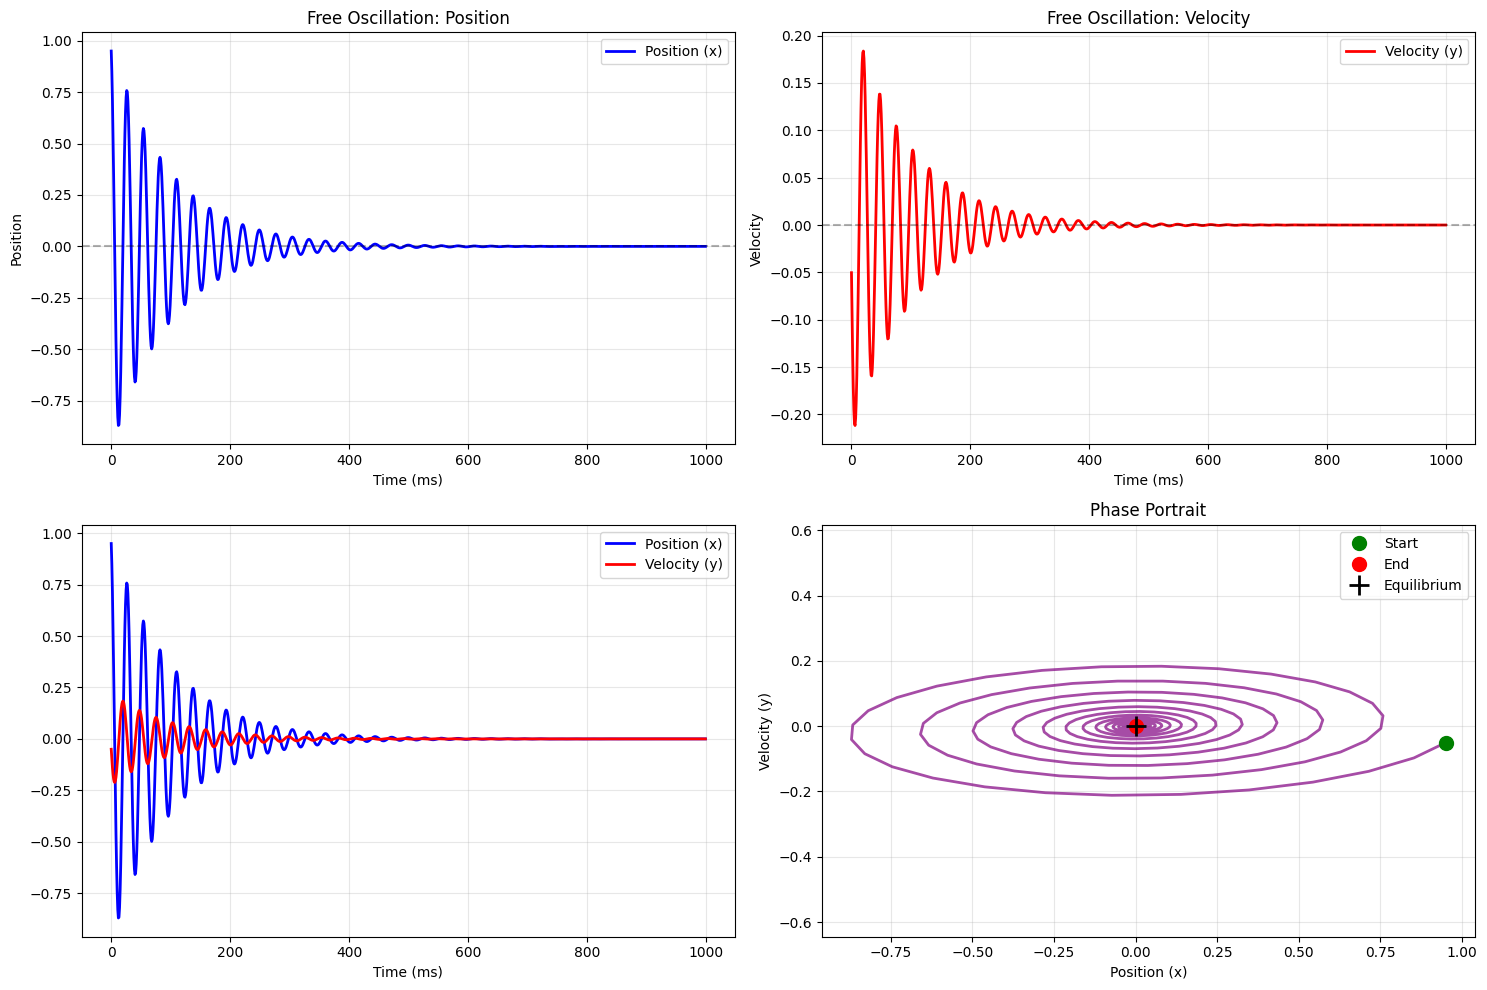

Observations:
1. Position oscillates with exponentially decaying amplitude (damping)
2. Velocity is 90° out of phase with position (leads by π/2)
3. Phase portrait spirals inward toward equilibrium (0, 0)
4. Approximate period: 28.0 ms (set by ω = 2π/28)


In [4]:
# Visualization: Time series and phase portrait
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 2, figure=fig)

# Panel 1: Position over time
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(times, x_trace, 'b-', linewidth=2, label='Position (x)')
ax1.axhline(0, color='k', linestyle='--', alpha=0.3)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Position')
ax1.set_title('Free Oscillation: Position')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Panel 2: Velocity over time
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(times, y_trace, 'r-', linewidth=2, label='Velocity (y)')
ax2.axhline(0, color='k', linestyle='--', alpha=0.3)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Velocity')
ax2.set_title('Free Oscillation: Velocity')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Panel 3: Phase portrait (x vs y)
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(times, x_trace, 'b-', linewidth=2, label='Position (x)')
ax4.plot(times, y_trace, 'r-', linewidth=2, label='Velocity (y)')
ax4.set_xlabel('Time (ms)')
ax4.legend()
ax4.grid(True, alpha=0.3)

ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(x_trace, y_trace, 'purple', linewidth=2, alpha=0.7)
ax3.plot(x_trace[0], y_trace[0], 'go', markersize=10, label='Start')
ax3.plot(x_trace[-1], y_trace[-1], 'ro', markersize=10, label='End')
ax3.plot(0, 0, 'k+', markersize=15, markeredgewidth=2, label='Equilibrium')
ax3.set_xlabel('Position (x)')
ax3.set_ylabel('Velocity (y)')
ax3.set_title('Phase Portrait')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.axis('equal')

plt.tight_layout()
plt.show()

print("Observations:")
print("1. Position oscillates with exponentially decaying amplitude (damping)")
print("2. Velocity is 90° out of phase with position (leads by π/2)")
print(f"3. Phase portrait spirals inward toward equilibrium (0, 0)")
print(f"4. Approximate period: {28 * dt:.1f} ms (set by ω = 2π/28)")

#### 2.2.1 Constant Input

#### 2.2 Driven Oscillation

Now let's examine how the oscillator responds to different types of external inputs.

In [5]:
# Reset and apply constant input
model.init_all_states()
model.x.value = jnp.array([0.0])
model.y.value = jnp.array([0.0])

constant_input = 1.0  # constant drive


def step_inp(i):
    model.update(jnp.array([constant_input]))
    return model.x.value, model.y.value


x_const, y_const = brainstate.transform.for_loop(step_inp, np.arange(n_steps))

#### 2.2.2 Sinusoidal Input (Resonance)

In [6]:
# Reset and apply sinusoidal input at natural frequency
model.init_all_states()
model.x.value = jnp.array([0.0])
model.y.value = jnp.array([0.0])

omega_natural = 2 * np.pi / 28
sine_input = 0.5 * np.sin(omega_natural * np.arange(n_steps) * dt)


def step_inp2(i):
    sine_inp = 0.5 * jnp.sin(omega_natural * i * dt)
    model.update(sine_inp)
    return model.x.value, model.y.value


x_sine, y_sine = brainstate.transform.for_loop(step_inp2, np.arange(n_steps))

#### 2.2.3 Step Input (Transient Response)

In [7]:
# Reset and apply step input
model.init_all_states()
model.x.value = jnp.array([0.0])
model.y.value = jnp.array([0.0])

step_input = np.zeros(n_steps)
step_input[200:] = 1.0  # step at t=20ms


def step_inp3(inp):
    model.update(inp)
    return model.x.value, model.y.value


x_step, y_step = brainstate.transform.for_loop(step_inp3, step_input)

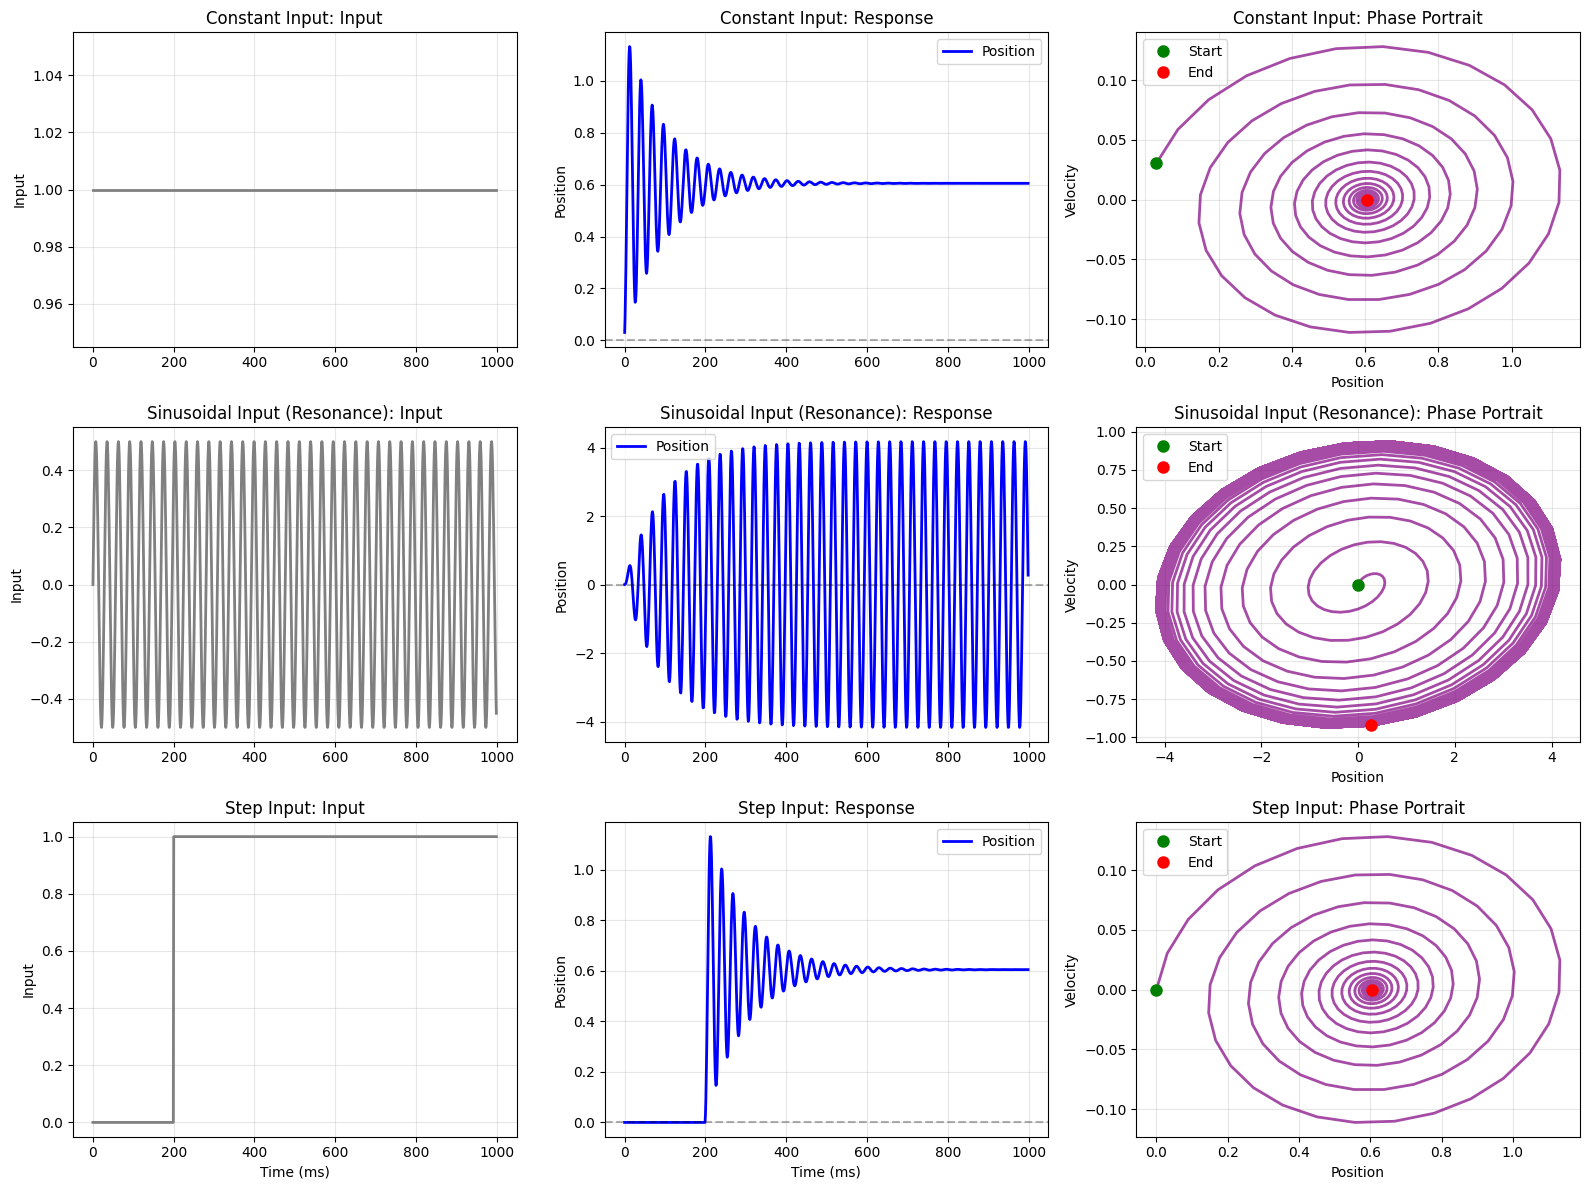

Key Observations:
1. Constant Input: Oscillates around non-zero equilibrium (offset by input)
2. Sinusoidal Input: Resonance amplifies response when input frequency matches ω
3. Step Input: Transient oscillations before settling to new equilibrium


In [8]:
# Visualization: Compare different input types
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

input_types = [
    ('Constant Input', [constant_input] * n_steps, x_const, y_const),
    ('Sinusoidal Input (Resonance)', sine_input, x_sine, y_sine),
    ('Step Input', step_input, x_step, y_step)
]

for row, (title, inp, x, y) in enumerate(input_types):
    # Input
    axes[row, 0].plot(times, inp, 'gray', linewidth=2)
    axes[row, 0].set_ylabel('Input')
    axes[row, 0].set_title(f'{title}: Input')
    axes[row, 0].grid(True, alpha=0.3)
    if row == 2:
        axes[row, 0].set_xlabel('Time (ms)')

    # Response (position)
    axes[row, 1].plot(times, x, 'b-', linewidth=2, label='Position')
    axes[row, 1].axhline(0, color='k', linestyle='--', alpha=0.3)
    axes[row, 1].set_ylabel('Position')
    axes[row, 1].set_title(f'{title}: Response')
    axes[row, 1].grid(True, alpha=0.3)
    axes[row, 1].legend()
    if row == 2:
        axes[row, 1].set_xlabel('Time (ms)')

    # Phase portrait
    axes[row, 2].plot(x, y, 'purple', linewidth=2, alpha=0.7)
    axes[row, 2].plot(x[0], y[0], 'go', markersize=8, label='Start')
    axes[row, 2].plot(x[-1], y[-1], 'ro', markersize=8, label='End')
    axes[row, 2].set_xlabel('Position')
    axes[row, 2].set_ylabel('Velocity')
    axes[row, 2].set_title(f'{title}: Phase Portrait')
    axes[row, 2].grid(True, alpha=0.3)
    axes[row, 2].legend()

plt.tight_layout()
plt.show()

print("Key Observations:")
print("1. Constant Input: Oscillates around non-zero equilibrium (offset by input)")
print("2. Sinusoidal Input: Resonance amplifies response when input frequency matches ω")
print("3. Step Input: Transient oscillations before settling to new equilibrium")

---

## PART 2: PARAMETER EXPLORATION

Now we systematically explore how each parameter controls oscillator behavior.

---

### Section 3: Natural Frequency (ω)

The natural frequency $\omega$ determines the intrinsic oscillation rate of the system.

In [9]:
# Sweep omega values
omega_values = np.linspace(0.1, 1.0, 10)
T_sweep = 500.0
n_steps_sweep = int(T_sweep / dt)
times_sweep = np.arange(n_steps_sweep) * dt
n_neuron = len(omega_values)

model_omega = brainmass.HORNStep(
    len(omega_values),
    omega=omega_values,
    gamma=0.01,
    alpha=0.04,
    v=0.0,
    h=dt
)
model_omega.init_all_states()
model_omega.x.value = jnp.full(n_neuron, 1.0)
model_omega.y.value = jnp.full(n_neuron, 0.0)


def step(i):
    model_omega.update(0.)
    return model_omega.x.value


omega_traces = brainstate.transform.for_loop(step, np.arange(n_steps_sweep))
omega_traces = np.array(omega_traces).T

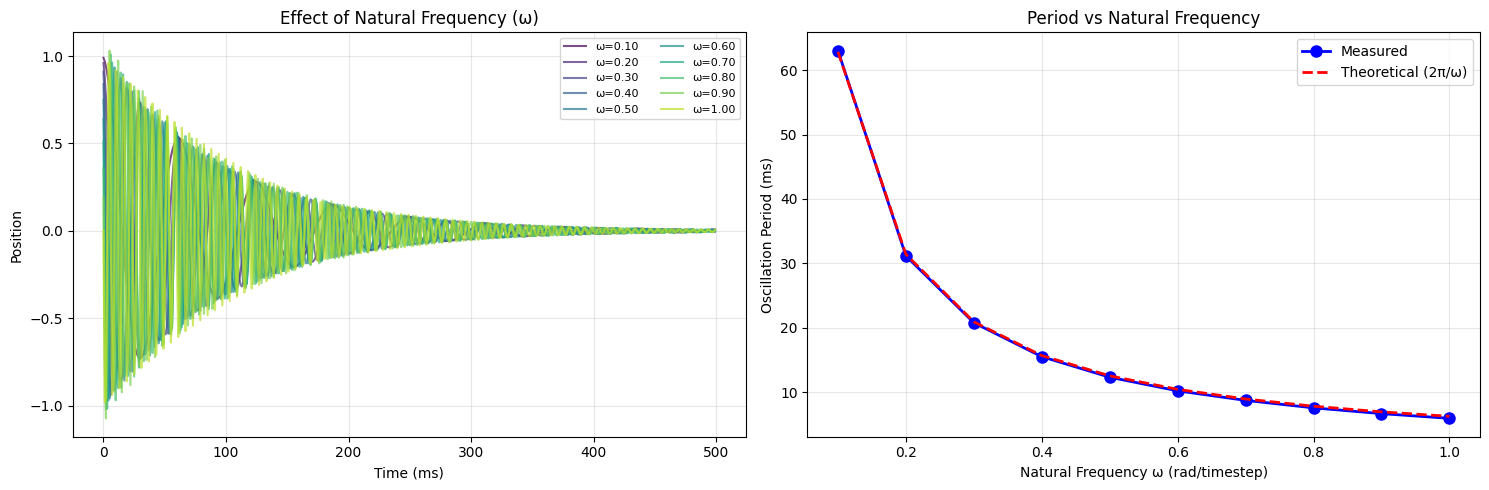

Key Findings:
1. Higher ω → faster oscillations (shorter period)
2. Relationship is inversely proportional: Period ≈ 2π/ω
3. Measured periods match theoretical predictions


In [10]:
from scipy.signal import find_peaks

# Visualization: Omega sweep
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Panel 1: Overlaid time series
cmap = plt.cm.viridis
for i, omega in enumerate(omega_values):
    color = cmap(i / len(omega_values))
    axes[0].plot(
        times_sweep,
        omega_traces[i],
        color=color,
        linewidth=1.5,
        alpha=0.7,
        label=f'ω={omega:.2f}'
    )
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Position')
axes[0].set_title('Effect of Natural Frequency (ω)')
axes[0].legend(ncol=2, fontsize=8, loc='upper right')
axes[0].grid(True, alpha=0.3)

# Panel 2: Period vs omega
periods = []
for i, trace in enumerate(omega_traces):
    # Find peaks to estimate period
    peaks, _ = find_peaks(trace, height=0.1)
    if len(peaks) > 1:
        avg_period = np.mean(np.diff(peaks)) * dt
        periods.append(avg_period)
    else:
        periods.append(np.nan)
periods = np.array(periods)
theoretical_periods = 2 * np.pi / omega_values * dt

axes[1].plot(omega_values, periods, 'bo-', linewidth=2, markersize=8, label='Measured')
axes[1].plot(omega_values, theoretical_periods, 'r--', linewidth=2, label='Theoretical (2π/ω)')
axes[1].set_xlabel('Natural Frequency ω (rad/timestep)')
axes[1].set_ylabel('Oscillation Period (ms)')
axes[1].set_title('Period vs Natural Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Findings:")
print(f"1. Higher ω → faster oscillations (shorter period)")
print(f"2. Relationship is inversely proportional: Period ≈ 2π/ω")
print(f"3. Measured periods match theoretical predictions")

### Section 4: Damping Coefficient (γ)

Damping controls how quickly oscillations decay to equilibrium.

In [33]:
# Sweep gamma values
gamma_values = np.logspace(-3, -0.5, 8)  # 0.001 to ~0.316
n_neuron = len(gamma_values)

model_gamma = brainmass.HORNStep(
    len(gamma_values),
    omega=0.224,
    gamma=gamma_values,
    alpha=0.04,
    v=0.0,
    h=dt
)
model_gamma.init_all_states()
model_gamma.x.value = jnp.full(n_neuron, 1.0)
model_gamma.y.value = jnp.full(n_neuron, 0.0)


def step(i):
    model_gamma.update(0.)
    return model_gamma.x.value


n_time = int(8e2 / dt)
gamma_traces = brainstate.transform.for_loop(step, np.arange(n_time))
gamma_traces = np.array(gamma_traces).T

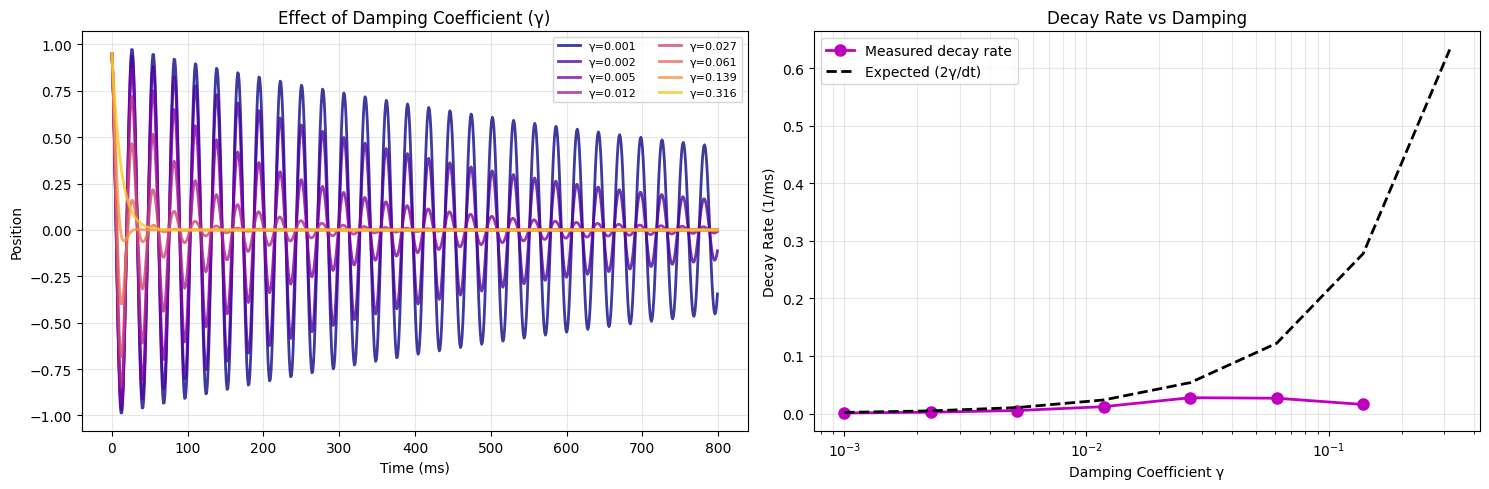

Damping Regimes:
Critical damping: γ_c = ω = 0.224
Underdamped: γ < 0.224 (oscillatory decay)
Critically damped: γ ≈ 0.224 (fastest non-oscillatory decay)
Overdamped: γ > 0.224 (slow non-oscillatory decay)

Most gamma values tested are underdamped (typical for neural oscillations)


In [34]:
# Visualization: Gamma sweep
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Panel 1: Overlaid time series
cmap = plt.cm.plasma
for i, gamma in enumerate(gamma_values):
    color = cmap(i / len(gamma_values))
    axes[0].plot(
        np.arange(n_time) * dt,
        gamma_traces[i],
        color=color,
        linewidth=2,
        alpha=0.8,
        label=f'γ={gamma:.3f}',
    )
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Position')
axes[0].set_title('Effect of Damping Coefficient (γ)')
axes[0].legend(ncol=2, fontsize=8)
axes[0].grid(True, alpha=0.3)

# Panel 2: Decay rate analysis
decay_rates = []
for trace in gamma_traces:
    # Fit exponential decay to amplitude envelope
    peaks, _ = find_peaks(np.abs(trace))
    if len(peaks) > 3:
        peak_times = peaks * dt
        peak_amplitudes = np.abs(trace[peaks])
        # Fit log(amplitude) = -decay_rate * t + const
        coeffs = np.polyfit(peak_times, np.log(peak_amplitudes + 1e-10), 1)
        decay_rates.append(-coeffs[0])  # negative slope
    else:
        decay_rates.append(np.nan)

decay_rates = np.array(decay_rates)

axes[1].plot(gamma_values, decay_rates, 'mo-', linewidth=2, markersize=8, label='Measured decay rate')
axes[1].plot(gamma_values, 2 * gamma_values / dt, 'k--', linewidth=2, label='Expected (2γ/dt)')
axes[1].set_xlabel('Damping Coefficient γ')
axes[1].set_ylabel('Decay Rate (1/ms)')
axes[1].set_title('Decay Rate vs Damping')
axes[1].set_xscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Classify damping regimes
omega = 0.224
gamma_critical = omega  # critical damping when γ = ω

print("Damping Regimes:")
print(f"Critical damping: γ_c = ω = {gamma_critical:.3f}")
print(f"Underdamped: γ < {gamma_critical:.3f} (oscillatory decay)")
print(f"Critically damped: γ ≈ {gamma_critical:.3f} (fastest non-oscillatory decay)")
print(f"Overdamped: γ > {gamma_critical:.3f} (slow non-oscillatory decay)")
print(f"\nMost gamma values tested are underdamped (typical for neural oscillations)")

### Section 5: Excitability (α)

The excitability parameter $\alpha$ controls how strongly the oscillator responds to inputs.

In [13]:
# Sweep alpha values
alpha_values = np.linspace(0.01, 0.2, 10)
n_neuron = len(alpha_values)

model_alpha = brainmass.HORNStep(
    len(alpha_values),
    omega=0.224,
    gamma=0.01,
    alpha=alpha_values,
    v=0.0,
    h=dt
)
model_alpha.init_all_states()
model_alpha.x.value = jnp.full(n_neuron, 1.0)
model_alpha.y.value = jnp.full(n_neuron, 0.0)

# Apply constant input to see gain effect
test_input = 1.0


def step(i):
    model_alpha.update(test_input)
    return model_alpha.x.value


alpha_traces = brainstate.transform.for_loop(step, np.arange(n_steps_sweep))
alpha_traces = np.array(alpha_traces).T

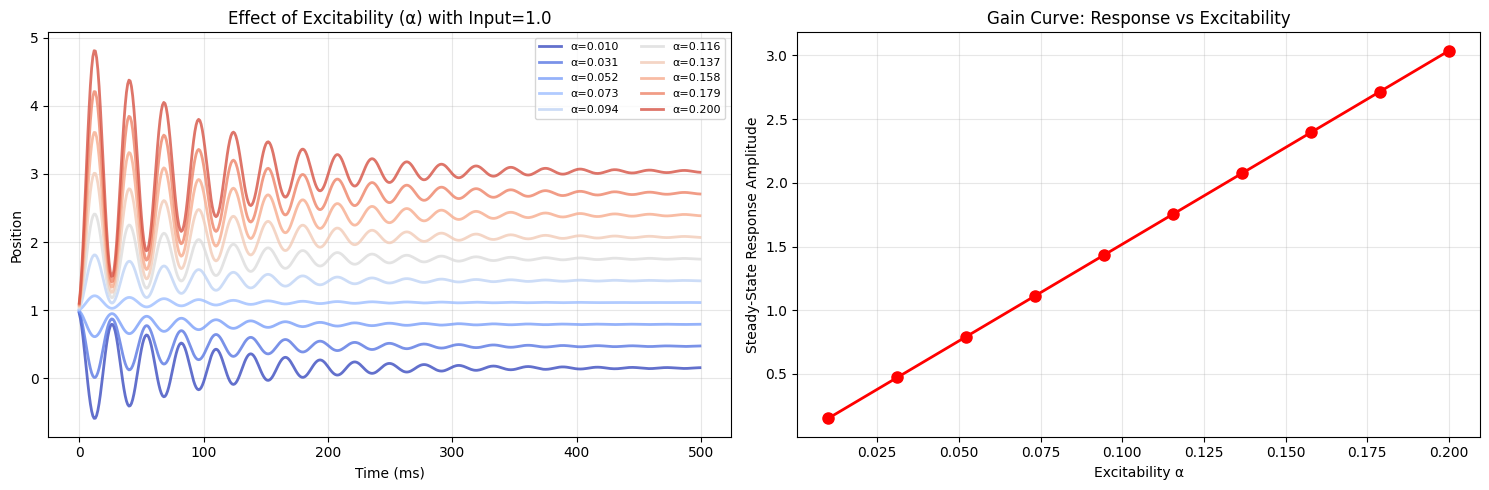

Key Findings:
1. Higher α → larger response amplitude (increased gain)
2. Relationship is approximately linear for small α
3. Excitability controls input sensitivity without affecting frequency
4. Neural interpretation: α represents synaptic efficacy/neuromodulation


In [14]:
# Visualization: Alpha sweep
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Panel 1: Overlaid time series
cmap = plt.cm.coolwarm
for i, alpha in enumerate(alpha_values):
    color = cmap(i / len(alpha_values))
    axes[0].plot(times_sweep, alpha_traces[i], color=color,
                 linewidth=2, alpha=0.8, label=f'α={alpha:.3f}')
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Position')
axes[0].set_title(f'Effect of Excitability (α) with Input={test_input}')
axes[0].legend(ncol=2, fontsize=8)
axes[0].grid(True, alpha=0.3)

# Panel 2: Response amplitude vs alpha (gain curve)
steady_state_amplitudes = []
for trace in alpha_traces:
    # Take mean of last 20% of simulation (steady state)
    steady_idx = int(0.8 * len(trace))
    steady_amplitude = np.mean(np.abs(trace[steady_idx:]))
    steady_state_amplitudes.append(steady_amplitude)

steady_state_amplitudes = np.array(steady_state_amplitudes)

axes[1].plot(alpha_values, steady_state_amplitudes, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Excitability α')
axes[1].set_ylabel('Steady-State Response Amplitude')
axes[1].set_title('Gain Curve: Response vs Excitability')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Findings:")
print(f"1. Higher α → larger response amplitude (increased gain)")
print(f"2. Relationship is approximately linear for small α")
print(f"3. Excitability controls input sensitivity without affecting frequency")
print(f"4. Neural interpretation: α represents synaptic efficacy/neuromodulation")

### Section 6: Amplitude Feedback (v)

The amplitude feedback parameter $v$ provides position-dependent modulation, implementing activity-dependent gain control.

In [15]:
@brainstate.transform.jit
def simulate_v(v_values):
    model_v = brainmass.HORNStep(
        len(v_values),
        omega=0.224,
        gamma=0.01,
        alpha=0.04,
        v=v_values,
        h=dt
    )
    model_v.init_all_states()
    model_v.x.value = jnp.full(len(v_values), 1.0)
    model_v.y.value = jnp.full(len(v_values), 0.0)

    def step(i):
        model_v.update(0.0)
        return model_v.x.value, model_v.y.value

    return brainstate.transform.for_loop(step, np.arange(n_steps_sweep))

In [16]:
# Sweep v values
v_values = np.linspace(0.0, 0.3, 7)
v_traces = np.array(simulate_v(v_values)[0]).T

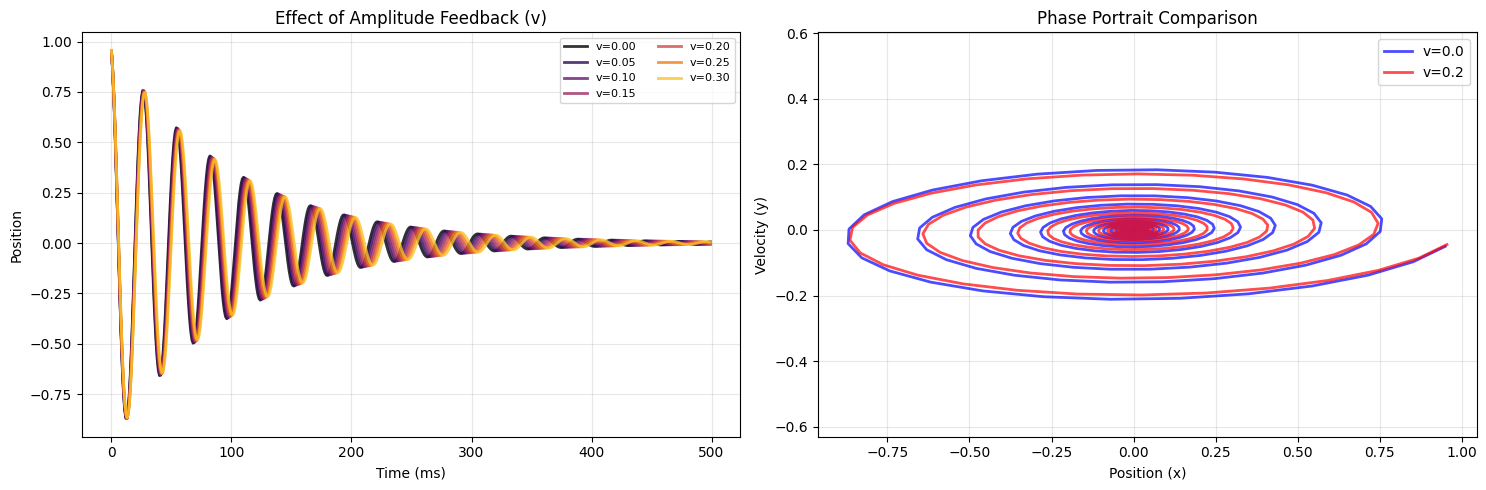

Key Findings:
1. Positive v modifies decay rate and can stabilize/destabilize oscillations
2. v=0: Standard damped oscillation (baseline)
3. Small v: Modified effective damping
4. Larger v values can lead to different dynamical regimes
5. Neural interpretation: Activity-dependent adaptation (e.g., spike-frequency adaptation)


In [17]:
# Visualization: v sweep
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Panel 1: Overlaid time series
cmap = plt.cm.inferno
for i, v in enumerate(v_values):
    color = cmap(i / len(v_values))
    axes[0].plot(times_sweep, v_traces[i], color=color,
                 linewidth=2, alpha=0.8, label=f'v={v:.2f}')

axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Position')
axes[0].set_title('Effect of Amplitude Feedback (v)')
axes[0].legend(ncol=2, fontsize=8)
axes[0].grid(True, alpha=0.3)

# Panel 2: Phase portraits comparing v=0 and v=0.2
v_test = [0.0, 0.2]
x_list, y_list = simulate_v(jnp.asarray(v_test))
for idx, v in enumerate(v_test):
    color = 'blue' if v == 0.0 else 'red'
    axes[1].plot(
        x_list[:, idx],
        y_list[:, idx],
        color=color,
        linewidth=2,
        alpha=0.7,
        label=f'v={v}'
    )
axes[1].set_xlabel('Position (x)')
axes[1].set_ylabel('Velocity (y)')
axes[1].set_title('Phase Portrait Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axis('equal')

plt.tight_layout()
plt.show()

print("Key Findings:")
print(f"1. Positive v modifies decay rate and can stabilize/destabilize oscillations")
print(f"2. v=0: Standard damped oscillation (baseline)")
print(f"3. Small v: Modified effective damping")
print(f"4. Larger v values can lead to different dynamical regimes")
print(f"5. Neural interpretation: Activity-dependent adaptation (e.g., spike-frequency adaptation)")

---

## PART 3: NETWORK DYNAMICS

Now we scale from single oscillators to networks, exploring coupling patterns and emergent collective behaviors.

---

### Section 7: Homogeneous Network

We start with a network of **identical oscillators** to understand baseline collective dynamics and the effects of coupling.

In [18]:
# Network parameters
N_units = 16
T_net = 1000.0
n_steps_net = int(T_net / dt)
times_net = np.arange(n_steps_net) * dt

# Homogeneous network: all oscillators identical (no coupling first)
model_homo = brainmass.HORNStep(
    N_units,
    omega=0.224,
    gamma=0.01,
    alpha=0.04,
    v=0.0,
    h=dt
)
model_homo.init_all_states()

# Random initial conditions
np.random.seed(42)
model_homo.x.value = jnp.array(np.random.randn(N_units) * 0.5)
model_homo.y.value = jnp.array(np.random.randn(N_units) * 0.1)


# Simulate without coupling
def step(i):
    model_homo.update(0.)
    return model_homo.x.value


x_homo_uncoupled = brainstate.transform.for_loop(step, times_net)
x_homo_uncoupled = np.array(x_homo_uncoupled)

print(f"Simulated {N_units} uncoupled oscillators for {T_net} ms")

Simulated 16 uncoupled oscillators for 1000.0 ms


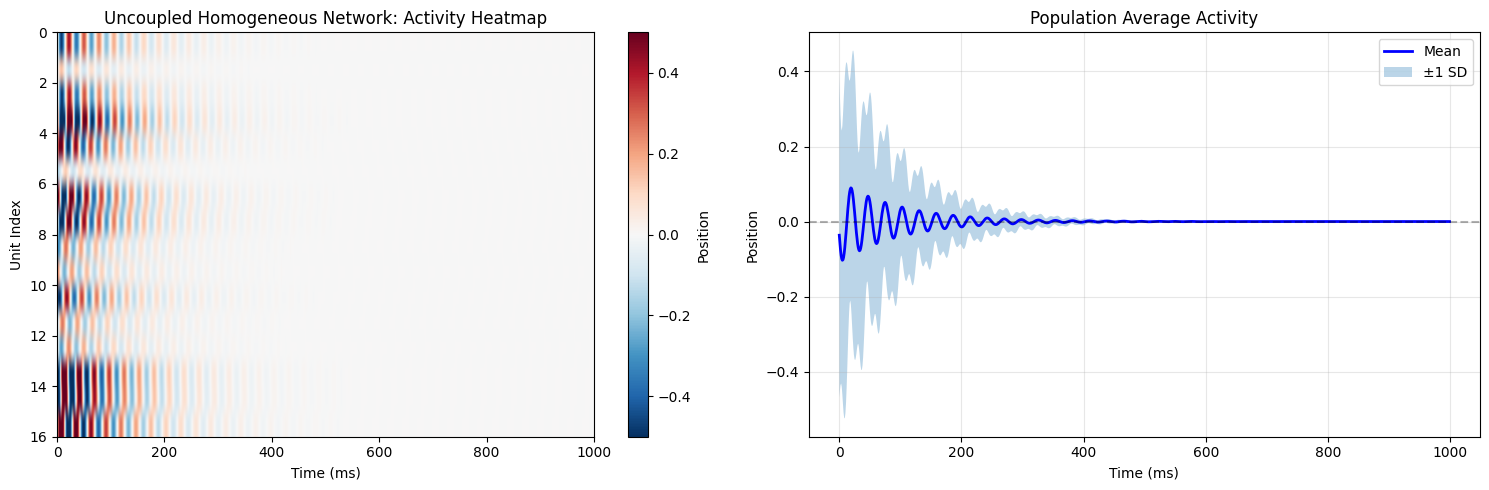

Observations:
1. All oscillators have same intrinsic frequency (identical parameters)
2. Random initial conditions → different phases
3. Without coupling, units oscillate independently
4. Population mean ~ 0 due to phase cancellation


In [19]:
# Visualization: Homogeneous network activity
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Panel 1: Raster plot (heatmap)
im = axes[0].imshow(x_homo_uncoupled.T, aspect='auto', cmap='RdBu_r',
                    extent=[0, T_net, N_units, 0], vmin=-0.5, vmax=0.5)
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Unit Index')
axes[0].set_title('Uncoupled Homogeneous Network: Activity Heatmap')
plt.colorbar(im, ax=axes[0], label='Position')

# Panel 2: Mean activity across all units
mean_activity = np.mean(x_homo_uncoupled, axis=1)
std_activity = np.std(x_homo_uncoupled, axis=1)

axes[1].plot(times_net, mean_activity, 'b-', linewidth=2, label='Mean')
axes[1].fill_between(times_net, mean_activity - std_activity,
                     mean_activity + std_activity, alpha=0.3, label='±1 SD')
axes[1].axhline(0, color='k', linestyle='--', alpha=0.3)
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Position')
axes[1].set_title('Population Average Activity')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations:")
print(f"1. All oscillators have same intrinsic frequency (identical parameters)")
print(f"2. Random initial conditions → different phases")
print(f"3. Without coupling, units oscillate independently")
print(f"4. Population mean ~ 0 due to phase cancellation")

### Section 8: Heterogeneous Network

Real neural populations exhibit **heterogeneity** in their intrinsic properties. Let's explore networks with distributed parameters.

In [20]:
# Create heterogeneous network with distributed omega and gamma values
np.random.seed(123)
omega_dist = np.random.uniform(0.15, 0.35, N_units)  # Frequency distribution
gamma_dist = np.random.uniform(0.005, 0.015, N_units)  # Damping distribution

model_hetero = brainmass.HORNStep(
    N_units,
    omega=omega_dist,
    gamma=gamma_dist,
    alpha=0.04,
    v=0.0,
    h=1.0
)

model_hetero.init_all_states()
model_hetero.x.value = jnp.array(np.random.randn(N_units) * 0.5)
model_hetero.y.value = jnp.array(np.random.randn(N_units) * 0.1)

# Simulate without coupling
def step(i):
    model_hetero.update(0.)
    return model_hetero.x.value


x_hetero = brainstate.transform.for_loop(step, np.arange(n_steps_net))
x_hetero = np.array(x_hetero)

print(f"Simulated heterogeneous network:")
print(f"  Omega range: [{omega_dist.min():.3f}, {omega_dist.max():.3f}] rad/timestep")
print(f"  Gamma range: [{gamma_dist.min():.3f}, {gamma_dist.max():.3f}]")

Simulated heterogeneous network:
  Omega range: [0.162, 0.346] rad/timestep
  Gamma range: [0.006, 0.013]


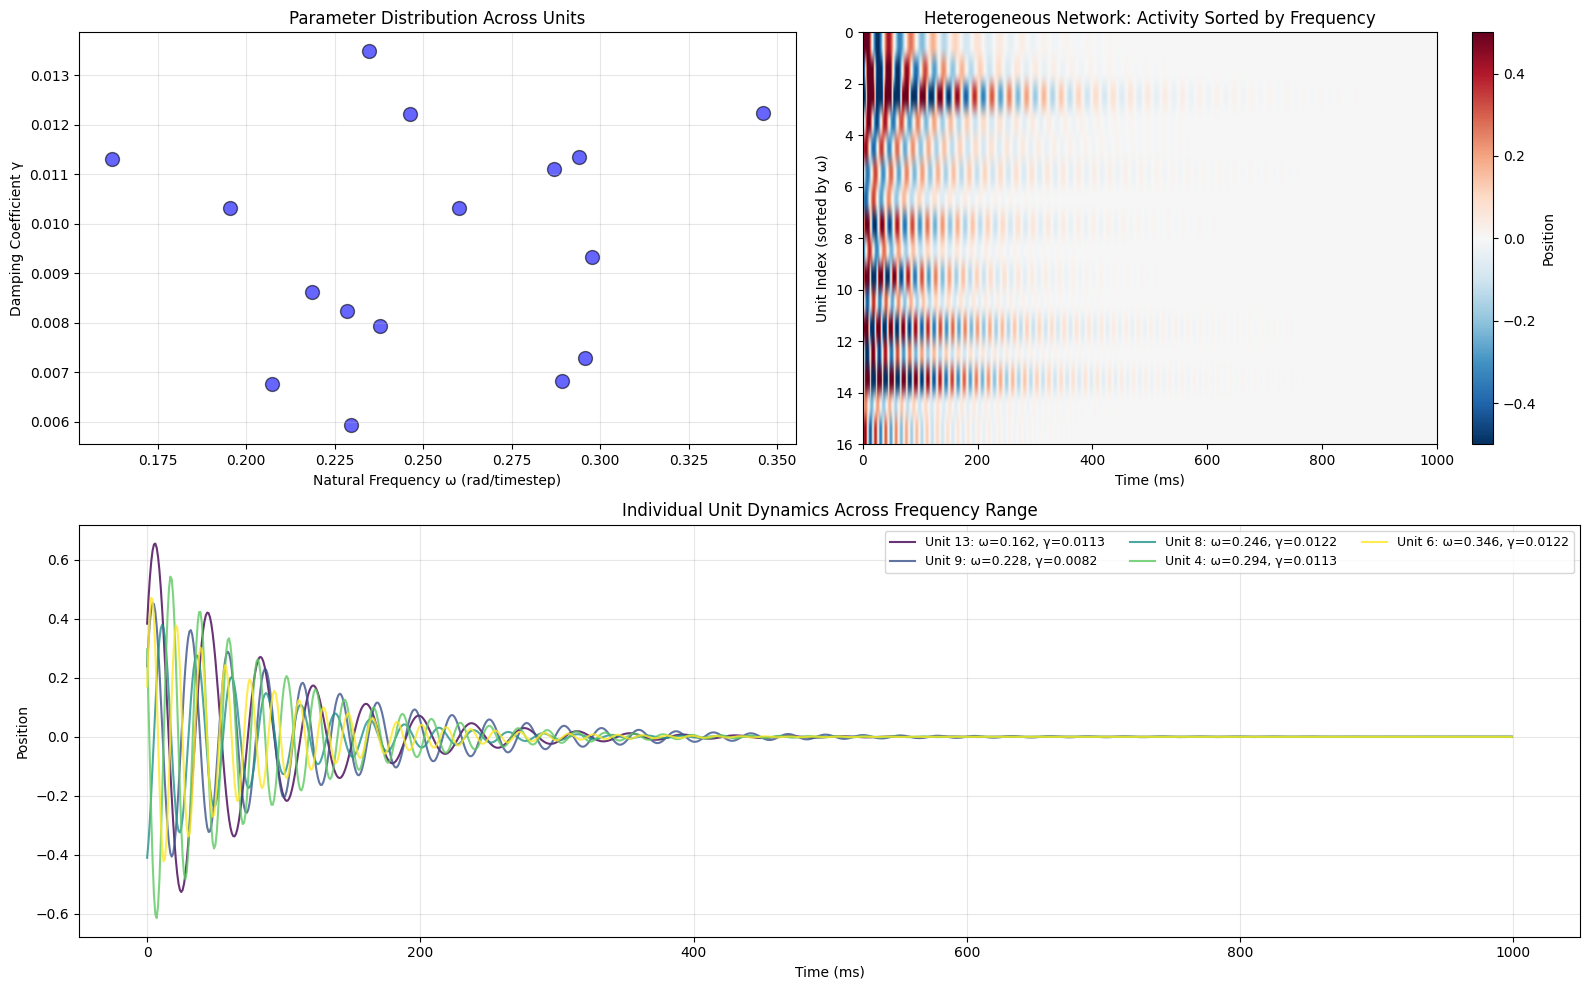

\nKey Observations:
1. Units with different ω oscillate at different frequencies
2. Frequency clustering visible in sorted heatmap (diagonal stripes)
3. Units with similar ω show correlated activity patterns
4. Heterogeneity increases richness of network dynamics
5. Relevant for modeling diverse neural populations


In [21]:
# Visualization: Heterogeneous network
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, figure=fig)

# Panel 1: Parameter distributions
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(omega_dist, gamma_dist, c='blue', s=100, alpha=0.6, edgecolors='black')
ax1.set_xlabel('Natural Frequency ω (rad/timestep)')
ax1.set_ylabel('Damping Coefficient γ')
ax1.set_title('Parameter Distribution Across Units')
ax1.grid(True, alpha=0.3)

# Panel 2: Activity heatmap sorted by omega
ax2 = fig.add_subplot(gs[0, 1])
sorted_idx = np.argsort(omega_dist)
im = ax2.imshow(x_hetero[:, sorted_idx].T,
                aspect='auto',
                cmap='RdBu_r',
                extent=[0, T_net, N_units, 0],
                vmin=-0.5,
                vmax=0.5)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Unit Index (sorted by ω)')
ax2.set_title('Heterogeneous Network: Activity Sorted by Frequency')
plt.colorbar(im, ax=ax2, label='Position')

# Panel 3: Individual traces for units with different omega
ax3 = fig.add_subplot(gs[1, :])
# Select 5 units spanning the omega range
selected_units = sorted_idx[[0, 4, 8, 12, 15]]
colors = plt.cm.viridis(np.linspace(0, 1, 5))

for idx, unit in enumerate(selected_units):
    ax3.plot(times_net, x_hetero[:, unit], color=colors[idx],
             linewidth=1.5, alpha=0.8,
             label=f'Unit {unit}: ω={omega_dist[unit]:.3f}, γ={gamma_dist[unit]:.4f}')

ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Position')
ax3.set_title('Individual Unit Dynamics Across Frequency Range')
ax3.legend(ncol=3, fontsize=9)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Observations:")
print(f"1. Units with different ω oscillate at different frequencies")
print(f"2. Frequency clustering visible in sorted heatmap (diagonal stripes)")
print(f"3. Units with similar ω show correlated activity patterns")
print(f"4. Heterogeneity increases richness of network dynamics")
print(f"5. Relevant for modeling diverse neural populations")

## References:

1. Rusch T K, Mishra S. "Coupled Oscillatory Recurrent Neural Network (coRNN): An accurate and (gradient) stable architecture for learning long time dependencies." *ICLR 2021*.

2. Buzsáki G, Draguhn A. "Neuronal oscillations in cortical networks." *Science* 304.5679 (2004): 1926-1929.

3. Breakspear M. "Dynamic models of large-scale brain activity." *Nature Neuroscience* 20.3 (2017): 340-352.

4. Goldstein H, Poole C, Safko J. *Classical Mechanics* (3rd ed.). Addison Wesley, 2002.
